In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn

import pandas as pd
import os
import pathlib
import shutil
import cv2
import PIL

TEXT_COLOR = 'black'

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
full_gt = pd.read_csv('full-gt.csv')
detection_srt = pathlib.Path('full-frames/rtsd-frames')
full_gt

,filename,x_from,y_from,width,height,sign_class,sign_id
0,autosave01_02_2012_09_13_33.jpg,649,376,18,18,2_1,0
1,autosave01_02_2012_09_13_34.jpg,671,356,20,21,2_1,0
2,autosave01_02_2012_09_13_35.jpg,711,332,27,26,2_1,0
3,autosave01_02_2012_09_13_36.jpg,764,290,37,36,2_1,0
4,autosave01_02_2012_09_13_36.jpg,684,384,17,17,1_23,1
...,...,...,...,...,...,...,...
104353,autosave24_10_2013_13_18_37_1.jpg,622,394,27,16,5_15_7,2565
104354,autosave24_10_2013_13_18_37_2.jpg,638,387,31,18,5_15_7,2565
104355,autosave24_10_2013_13_18_38_0.jpg,647,385,33,20,5_15_7,2565
104356,autosave24_10_2013_13_18_38_1.jpg,668,378,41,23,5_15_7,2565


In [157]:
def showPicture(path=None, full_gt_index=None, img=None, ax=None, figsize=(5, 5)):
    if img.any() != None:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    if path != None:
        pass
    else:
        if full_gt_index == None:
            assert 1 != 0, '1'
        else:
            path = train_dir / full_gt.iloc[full_gt_index]['filename']
        
            img = cv2.imread(str(path))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    fig = plt.figure(figsize=figsize)
    
    plt.imshow(img)
    plt.axis('off')
    # plt.show()

def getRandomImagePath():
    return str(detection_srt / full_gt.sample()['filename'].values[0])


def getSignCoordinates(path=None, filename=None):
    if path == None and filename == None:
        assert 1 != 0, 'cannot identify picture'
    if path:
        filename = str(path).split(sep='\\')[-1]
    located_data = full_gt.loc[full_gt['filename'] == filename]
    return located_data[['x_from', 'y_from', 'width', 'height', 'sign_class']].to_numpy()
    
        
def getMaskedImage(path=None, filename=None):
    if path == None and filename == None:
        assert 1 != 0, 'cannot identify picture'
    if path:
        filename = str(path).split(sep='\\')[-1]
    
    img = cv2.imread(str(detection_srt / filename))
    mask = np.zeros(img.shape[:2], dtype="uint8")
        
    for sign in getSignCoordinates(filename=filename):        
        cv2.rectangle(mask, (sign[0], sign[1]), (sign[0] + sign[2], sign[1] + sign[3]), 255, -1)
        
    return cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)

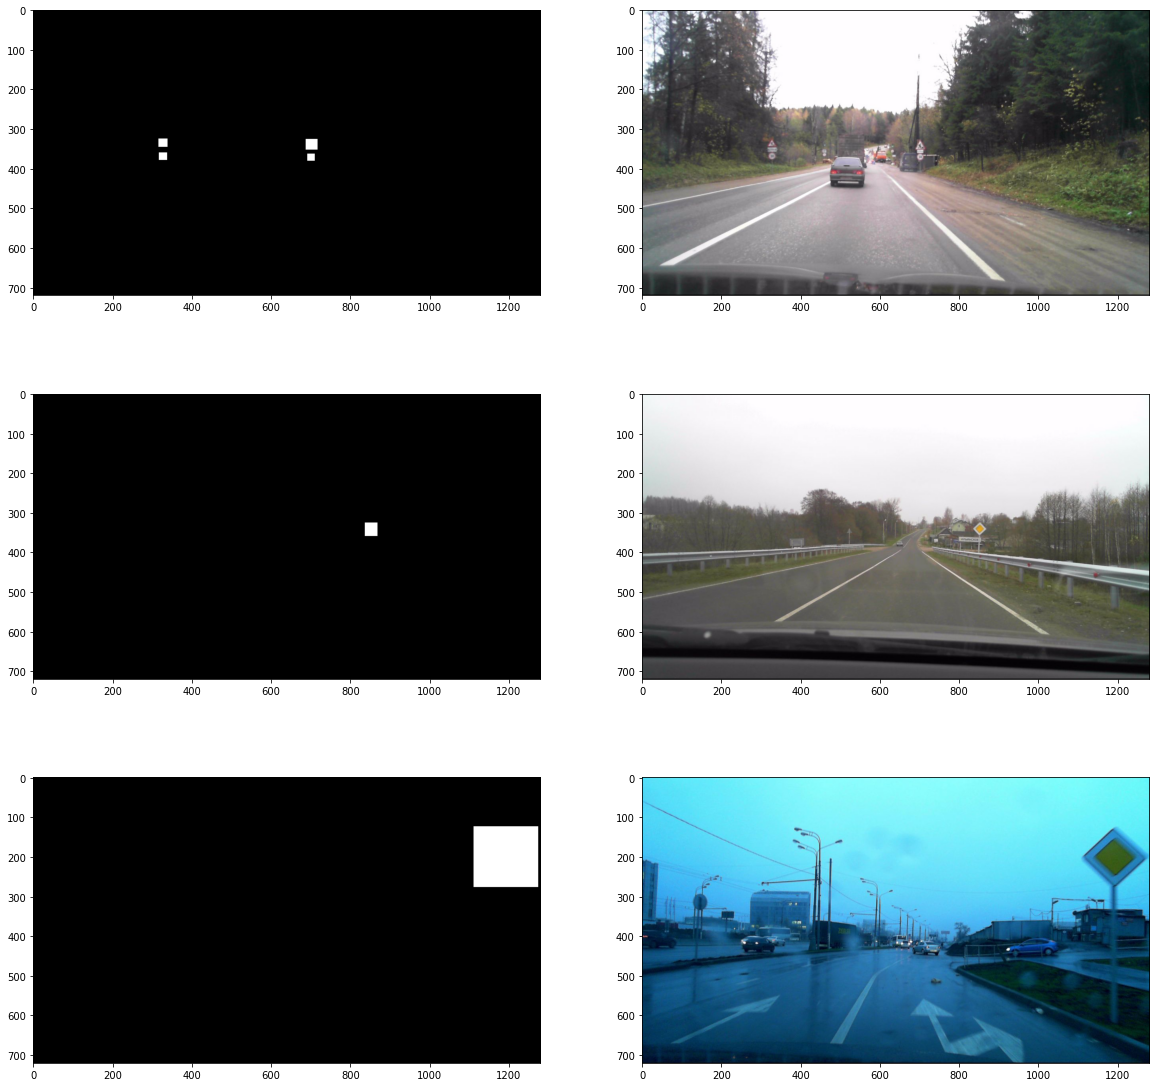

In [160]:
# getSignCoordinates(filename='autosave16_04_2013_12_01_56_1.jpg') # 3
# getSignCoordinates(filename='autosave01_02_2012_09_13_33.jpg')   # 1
# getSignCoordinates(filename='autosave01_02_2012_09_13_32.jpg')     # 0
# getMaskedImage(filename='autosave16_04_2013_12_01_56_1.jpg')


img=getMaskedImage(getRandomImagePath())

f = plt.figure(figsize=(20,20))


for i in range(6):
    ax = f.add_subplot(3, 2, i+1)
    # sampleImagePath = getRandomImagePath()
    
    if (i % 2 == 0):
        sampleImagePath = getRandomImagePath()
        ax.imshow(getMaskedImage(sampleImagePath))
    else:
        img = cv2.imread(sampleImagePath)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        ax.imshow(img)
        
        
plt.show()
# showPicture(img=getMaskedImage(getRandomImagePath()))